In [ ]:
!pip3 install patool

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 3.6 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import gdown
import patoolib
import shutil
url = "https://drive.google.com/uc?export=download&id=1LhPIsFmwfs7TI_cbXHvWKF5aDPP8CbV_"
output = 'dataset.rar'
gdown.download(url, output, quiet=False)
patoolib.extract_archive(output, outdir="./")

Downloading...
From: https://drive.google.com/uc?export=download&id=1LhPIsFmwfs7TI_cbXHvWKF5aDPP8CbV_
To: /content/dataset.rar
100%|██████████| 156M/156M [00:01<00:00, 79.0MB/s]


patool: Extracting dataset.rar ...
patool: running /usr/bin/unrar x -- /content/dataset.rar
patool:     with cwd='./'
patool: ... dataset.rar extracted to `./'.


'./'

In [ ]:
import cv2
import numpy as np
import pandas as pd
import xml.etree.ElementTree as xet
from glob import glob
import os
import matplotlib.pyplot as plt

WORKING_DIR = os.getcwd()
ANN_PATH = os.path.join(WORKING_DIR,"platedata1","annotations")
IMG_PATH = os.path.join(WORKING_DIR,"platedata1","images")
MODEL_SAVE_PATH = os.path.join(WORKING_DIR,"saved_models")

In [ ]:
imgs,bboxes = [],[]
for img_name in os.listdir(IMG_PATH):
  img_path = os.path.join(IMG_PATH,img_name)
  ann_file_name = img_name.split(".")[0]+'.xml'
  ann_path = os.path.join(ANN_PATH,ann_file_name)

  root = xet.parse(ann_path).getroot()
  member_object=root.find('object')
  labels_info=member_object.find('bndbox')
  xmin = int(labels_info.find('xmin').text)
  xmax = int(labels_info.find('xmax').text)
  ymin = int(labels_info.find('ymin').text)
  ymax = int(labels_info.find('ymax').text)

  img = cv2.imread(img_path)
  h,w,_ = img.shape
  img = cv2.resize(img,(224,224))
  imgs.append(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
  bboxes.append(np.array([xmin/w,ymin/h,xmax/w,ymax/h]))


imgs = np.array(imgs)  
bboxes = np.array(bboxes)

print(imgs.shape,bboxes.shape)

(710, 224, 224, 3) (710, 4)


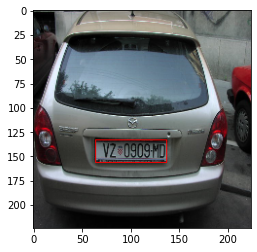

In [ ]:
def plot_box(img,bbox):
  xmin,ymin,xmax,ymax=bbox
  h,w,_=img.shape
  xmin,ymin,xmax,ymax=int(xmin*w),int(ymin*h),int(xmax*w),int(ymax*h)
  ann_img_rgb = cv2.rectangle(img.copy(), (xmin,ymin), (xmax,ymax), (255,0,0), 1).astype('float32')
  ann_img_bgr = cv2.cvtColor(ann_img_rgb,cv2.COLOR_RGB2BGR)
  return ann_img_bgr, ann_img_rgb

plt.imshow(plot_box(imgs[325],bboxes[325])[1]/255)# Image should be converted to RGB

In [ ]:
print(imgs.shape,bboxes.shape)

(710, 224, 224, 3) (710, 4)


In [ ]:
train_x , train_y= imgs[0:600], bboxes[0:600]
val_x , val_y= imgs[600:], bboxes[600:]

In [ ]:
from data_aug.bbox_util import *
from data_aug.data_aug import *

[[119.80403982  99.97847988 154.82361129 132.433506  ]]


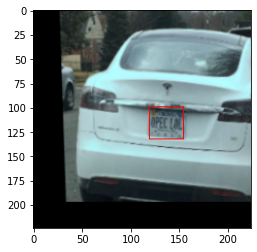

In [ ]:
# Testing for augmentation
box_ = np.array([bboxes_train[79].copy()])*224
img_ = imgs_train[79].copy()

img_, box_ = RandomHorizontalFlip()(img_, box_)
img_, box_ = RandomRotate(10)(img_, box_)
img_, box_ = RandomHSV(1, 1, 1)(img_, box_)
img_, box_=RandomScale(0.1, diff = 0)(img_, box_)
img_, box_ = RandomTranslate(0.2, diff = True)(img_, box_)
print(box_)
box_=box_[0]/224
plt.imshow(plot_box(img_, box_)[1]/255)

In [ ]:
def random_aug(img,box):
  box = np.array([box])*224
  img_, box_ = RandomHorizontalFlip()(img, box)
  img_, box_ = RandomRotate(10)(img_, box_)
  img_, box_ = RandomHSV(1, 1, 1)(img_, box_)
  img_, box_=RandomScale(0.12, diff = 0)(img_, box_)
  img_, box_ = RandomTranslate(0.2, diff = True)(img_, box_)
  box_=box_[0]/224

  return img_, box_

aug_train_x=list(imgs_train)
aug_train_y=list(bboxes_train)

for x,y in zip(imgs_train,bboxes_train):
  for i in range(4):
    try:
      img,box = random_aug(x.copy(),y.copy())
      aug_train_x.append(img)
      aug_train_y.append(box)
    except:
      pass
  
aug_train_x=np.array(aug_train_x)/255 #standardization
aug_train_y=np.array(aug_train_y)
p = np.random.permutation(aug_train_x.shape[0])
aug_train_x=aug_train_x[p]
aug_train_y=aug_train_y[p]

In [ ]:
print(aug_train_x.shape)
print(aug_train_y.shape)

(2822, 224, 224, 3)
(2822, 4)


Deep Learning Model

In [ ]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.models import Model
import tensorflow as tf
import keras

inception_resnet = InceptionResNetV2(weights="imagenet",include_top=False,
                                     input_tensor=Input(shape=(224,224,3))) 
inception_resnet.trainable=False                                            

headmodel = inception_resnet.output
headmodel = Flatten()(headmodel)
headmodel = Dense(128,activation="relu")(headmodel)   

headmodel = Dense(64,activation="relu")(headmodel)

headmodel = Dense(4,activation='linear')(headmodel) 

# ---------- model
model = Model(inputs=inception_resnet.input,outputs=headmodel)

In [ ]:
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), metrics=['accuracy'])

In [ ]:
model.save('od.h5')

In [ ]:
save = tf.keras.callbacks.ModelCheckpoint(
    "/content/od.h5",
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
)

history = model.fit(x=aug_train_x,y=aug_train_y,batch_size=10,epochs=20,
                    validation_data=(val_x/255,val_y), shuffle=True,callbacks=[save])


Epoch 1/20
283/283 [==============================] - 48s 98ms/step - loss: 0.9633 - accuracy: 0.2994 - val_loss: 0.1868 - val_accuracy: 0.4000
Epoch 2/20
283/283 [==============================] - 24s 84ms/step - loss: 0.4096 - accuracy: 0.3827 - val_loss: 0.1715 - val_accuracy: 0.4364
Epoch 3/20
283/283 [==============================] - 24s 86ms/step - loss: 0.0881 - accuracy: 0.5117 - val_loss: 0.0355 - val_accuracy: 0.5818
Epoch 4/20
283/283 [==============================] - 23s 81ms/step - loss: 0.0654 - accuracy: 0.6038 - val_loss: 0.0255 - val_accuracy: 0.5636
Epoch 5/20
283/283 [==============================] - 24s 85ms/step - loss: 0.1095 - accuracy: 0.5964 - val_loss: 0.0596 - val_accuracy: 0.7455
Epoch 6/20
283/283 [==============================] - 24s 83ms/step - loss: 0.0558 - accuracy: 0.5897 - val_loss: 0.0225 - val_accuracy: 0.5364
Epoch 7/20
283/283 [==============================] - 24s 83ms/step - loss: 0.0511 - accuracy: 0.6254 - val_loss: 0.0878 - val_accuracy:

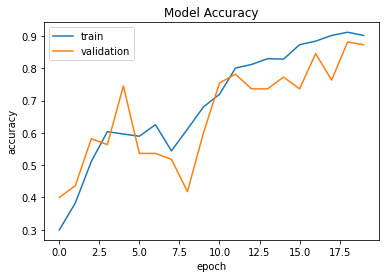

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'],loc='upper left')
plt.show()

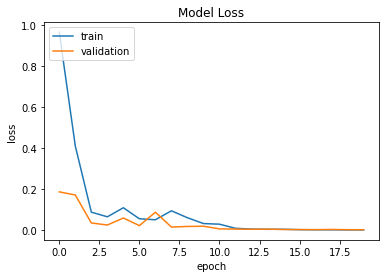

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'],loc='upper left')
plt.show()

In [ ]:
model.load_weights("/content/od.h5")

In [ ]:
scores=model.evaluate(val_x/255, val_y, verbose=0)
print("Score: %.2f%%" % (scores[1]*100)) 

Score: 88.18%


In [ ]:
def bb_intersection_over_union(boxA, boxB):
  # determine the (x, y)-coordinates of the intersection rectangle

  xA = max(boxA[0], boxB[0])
  yA = max(boxA[1], boxB[1])
  xB = min(boxA[2], boxB[2])
  yB = min(boxA[3], boxB[3])

  # compute the area of intersection rectangle
  interArea = abs(max((xB - xA, 0)) * max((yB - yA), 0))
  if interArea == 0:
      return 0
  # compute the area of both the prediction and ground-truth
  # rectangles
  boxAArea = abs((boxA[2] - boxA[0]) * (boxA[3] - boxA[1]))
  boxBArea = abs((boxB[2] - boxB[0]) * (boxB[3] - boxB[1]))

  # compute the intersection over union by taking the intersection
  # area and dividing it by the sum of prediction + ground-truth
  # areas - the interesection area
  iou = interArea / float(boxAArea + boxBArea - interArea)

  # return the intersection over union value
  return iou

In [ ]:
pred = model(val_x/255).numpy()
iou=[]
for A,B in zip(val_y,pred):
  iou.append(bb_intersection_over_union(A, B))
Final_iou = sum(iou)/len(iou)
print("Final_iou: ",Final_iou)

Final_iou:  0.4752263452428823


In [ ]:
# Saving model in saved model format. This will save the model in folder "saved_model"

tf.saved_model.save(model, "saved_model")

INFO:tensorflow:Assets written to: saved_model/assets
